# Analysis Pipeline

Given any segment of time-series data:
- Compute spectrogram (with window length and step length parameters)
- Fit exponential distribution over all frequencies and compute KS test value & p-value
- Compute SCV over same period (maybe throw out 1% outliers?)
- Compute the PSD from that time period (compute the spectrogram mean over time bins)
- Fooof PSD in 3 differe ways (take care to ignore 60Hz power line), and for each, save the fitted slope, offset, and fit error:

     1. Fit straight line over all frequencies (2-80Hz)

     2. Fit lorentzian over all frequencies (2-80Hz)

     3. Fit straight line over only the frequency ranges that are not significant under KS test

In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%matplotlib inline

# imports
from scv_funcs import access_nt as asc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import neurodsp as ndsp
from fooof import FOOOFGroup
from fooof import FOOOF
from scv_funcs import lfpca

In [8]:
#data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
session = 1
chan = [1,2,3,4] # start at 1
chan = range(1,128)

# with specified indices
# print(asc.get_cond(data_path, 0,1))
indices = [0,600000]
#indices= [0,0]
data = asc.get_ECoG(data_path, session, chan, indices)

In [9]:
# example of using LFPCA
fs = 1000
analysis_param = {'nperseg': 1000,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

# initialize object with data and parameters
nt_lfpca = lfpca.LFPCA(analysis_param)
nt_lfpca.populate_ts_data(data, fs)

# compute all spectral attributes
nt_lfpca.compute_all_spectral()

In [44]:
# compute KS-test fit against null exponential hypothesis
nt_lfpca.compute_KS_expfit() # this takes a few minutes

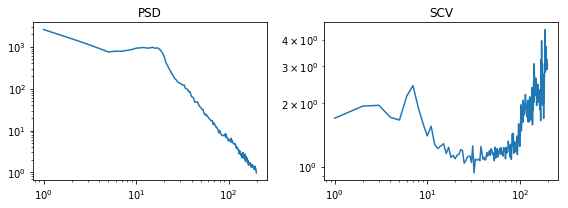

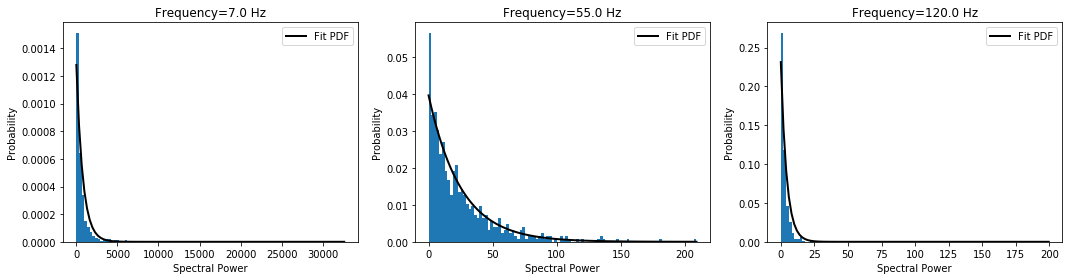

In [45]:
# plot power histrogram of a single channel and frequency
plot_chan = 8
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.loglog(nt_lfpca.f_axis, nt_lfpca.psd[plot_chan,:])
plt.title('PSD')
plt.subplot(1,2,2)
plt.loglog(nt_lfpca.f_axis, nt_lfpca.scv[plot_chan,:])
plt.title('SCV')
plt.tight_layout()

plot_freqs = [7,55,120]
plt.figure(figsize=(15,4))
for i,f in enumerate(plot_freqs):
    plt.subplot(1,3,i+1)
    nt_lfpca.plot_expfit(chan=plot_chan, freq_ind=f)

plt.tight_layout()

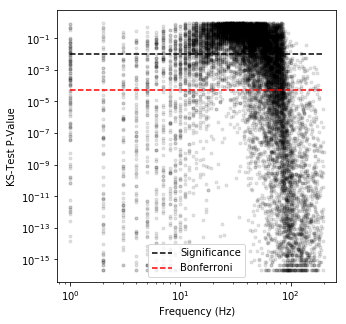

In [46]:
# plot
sig_alpha = 0.01
plt.figure(figsize=(5,5))
plt.loglog(nt_lfpca.f_axis, nt_lfpca.ks_pvals[:,:].T, 'k.', alpha=0.1)
plt.plot(nt_lfpca.f_axis, np.ones_like(nt_lfpca.f_axis)*sig_alpha, 'k--', label='Significance')
plt.plot(nt_lfpca.f_axis, np.ones_like(nt_lfpca.f_axis)*sig_alpha/len(nt_lfpca.f_axis), 'r--', label='Bonferroni')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('KS-Test P-Value');

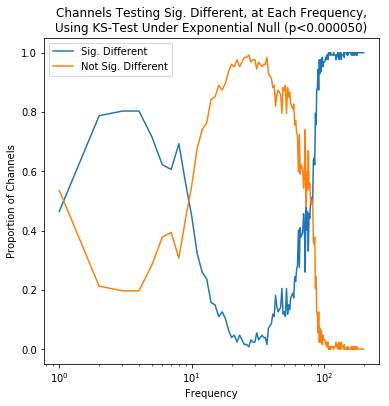

In [47]:
sig_thres = sig_alpha/len(nt_lfpca.f_axis)
bins = [0,sig_thres,1]
plt.figure(figsize=(6,6))
hs = np.array([np.histogram(nt_lfpca.ks_pvals[:,freq], bins)[0] for freq in range(len(nt_lfpca.f_axis))])
plt.semilogx(nt_lfpca.f_axis,hs/nt_lfpca.numchan)
plt.xlabel('Frequency')
plt.ylabel('Proportion of Channels')
plt.legend(('Sig. Different','Not Sig. Different'))
plt.title('Channels Testing Sig. Different, at Each Frequency,\nUsing KS-Test Under Exponential Null (p<%f)'%sig_thres);

In [48]:
# fit straight line
fg = FOOOFGroup(background_mode='fixed')
freq_range = [3,100]
fg.fit(nt_lfpca.f_axis, nt_lfpca.psd, freq_range)
linear_bg_params = [r.background_params for r in fg.get_results()]
linear_r2 = [r.r_squared for r in fg.get_results()]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



In [49]:
# fit lorentzian
fg = FOOOFGroup(background_mode='knee')
freq_range = [3,100]
fg.fit(nt_lfpca.f_axis, nt_lfpca.psd, freq_range)
lz_bg_params = [r.background_params for r in fg.get_results()]
lz_r2 = [r.r_squared for r in fg.get_results()]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



In [50]:
# fit line over "noise" region
# fit lorentzian
fg = FOOOFGroup(background_mode='fixed')
freq_range = [30,70]
fg.fit(nt_lfpca.f_axis, nt_lfpca.psd, freq_range)
noise_bg_params = [r.background_params for r in fg.get_results()]
noise_r2 = [r.r_squared for r in fg.get_results()]


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



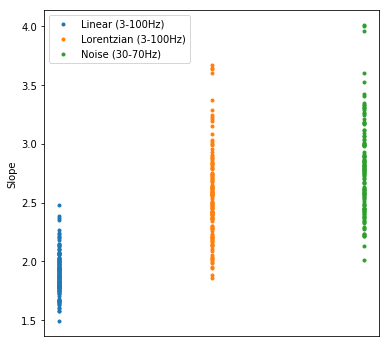

In [60]:
# compare fit slope parameters
slopes = np.array([[p[-1] for p in linear_bg_params], [p[-1] for p in lz_bg_params],[p[-1] for p in noise_bg_params]])
labels = ('Linear (3-100Hz)','Lorentzian (3-100Hz)', 'Noise (30-70Hz)')
plt.figure(figsize=(6,6))
for i in range(3):    
    plt.plot(i*np.ones(nt_lfpca.numchan),slopes[i,:], '.', label=labels[i])

plt.xticks([])
plt.ylabel('Slope')
plt.legend()

In [64]:
# correlation between fits
sp.stats.pearsonr(slopes[0,:], slopes[2,:])

(0.3398225690885155, 9.278715964416527e-05)